In [1]:
import nanomotif as nm
import logging as log
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
padding = 12


# Intro

Documentation of considerations in the implementation of the candidate selection. 

The selection is based on the sequences around methylation sites on the contig. At each methylated position, a frame of n posiion on each side of the methylation side is extracted and the index within this subsequence is considered relative to the methylation position (range: -n to n or 0:n*2).

The initial approach for candidate selection is outlined here:

1. Sample random sequences in contig at canonical bases (e.g. A when 6mA i evaluated)
2. Calculate [PSSM](https://cs.rice.edu/~ogilvie/comp571/pssm/) for contig sequences
3. Extract sequences in contig at all methylation sites
4. Set motif candidate to canonical base
2. While len(methylations sequences) > minimum sequences 
    - calculate PSSM for methylations sequences
    - Calculate KL-divergence from methylation PSSM to contig PSSM
    - Select position in sequence with highest distance
    - Select most frequent base at this position
    - Add base to motif
    - Score new motif
    - if score > threshold
        - remove seuqences with motif from methylation sequences
        - keep motif and score
    - else
        - select sequences with motif from methylation sequences

This should grow a motif by incorporation the most informative positions and bases first. 

In [2]:
ec_assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ec_pileup = nm.load_pileup("../data/ecoli/modkit.pileup.bed")

In [3]:
ec_motifs = nm.evaluate.process_sample(ec_assembly, ec_pileup.pileup, min_read_methylation_fraction = 0.7, cdf_position= 0.60)

DEBUG: ....................A.................... | cdf score: 0.000 | n seqs:    47566 | max kl: inf
DEBUG: ....................A.C.................. | cdf score: 0.000 | n seqs:    45669 | max kl: 0.860
DEBUG: ...................GA.C.................. | cdf score: 0.000 | n seqs:    40534 | max kl: 1.159
DEBUG: ...................GATC.................. | cdf score: 1.000 | n seqs:    38301 | max kl: 1.247
DEBUG: Saving candidate
DEBUG: ....................A.................... | cdf score: 0.000 | n seqs:     9504 | max kl: inf
DEBUG: ....................A.G.................. | cdf score: 0.000 | n seqs:     7607 | max kl: 0.227
DEBUG: ....................AGG.................. | cdf score: 0.000 | n seqs:     3610 | max kl: 0.524
DEBUG: ..................C.AGG.................. | cdf score: 0.000 | n seqs:     2391 | max kl: 1.060
DEBUG: ..................CCAGG.................. | cdf score: 0.000 | n seqs:     2163 | max kl: 1.221
DEBUG: .................GCCAGG.................. | cd

In [4]:
ec_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
"""..............…","BetaBernoulliModel(alpha=32136, beta=106)",1.0,"""contig_3""","""a""","""GATC""",1
"""..............…","BetaBernoulliModel(alpha=163, beta=74)",0.997562,"""contig_3""","""a""","""CGGCCAGG""",5
"""..............…","BetaBernoulliModel(alpha=586, beta=10)",1.0,"""contig_3""","""a""","""AAC......GTGC""",1
"""..............…","BetaBernoulliModel(alpha=577, beta=19)",1.0,"""contig_3""","""a""","""GCAC......GTT""",2
"""..............…","BetaBernoulliModel(alpha=11446, beta=24)",1.0,"""contig_3""","""m""","""CCTGG""",1
"""..............…","BetaBernoulliModel(alpha=11443, beta=27)",1.0,"""contig_3""","""m""","""CCAGG""",1
"""..............…","BetaBernoulliModel(alpha=178, beta=101)",0.905448,"""contig_3""","""m""","""TCCGATC""",2


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f23a626dfa0>


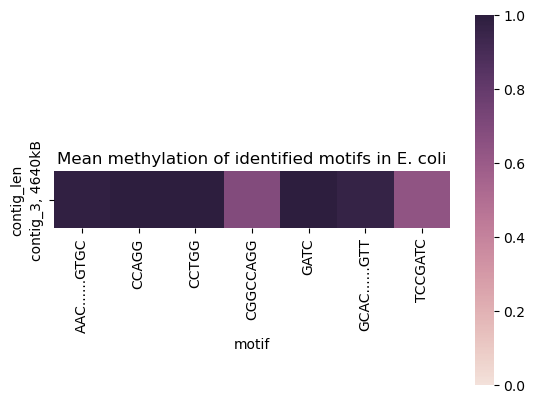

In [16]:
ec_motifs_plot = ec_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(ec_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(ec_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), cmap = cmap, square=True, vmin = 0, vmax = 1);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in E. coli");

# M. ruber

In [6]:
mr_assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mr_pileup = nm.load_pileup("../data/mruber/modkit.pileup.bed")

In [7]:
mr_motifs = nm.evaluate.process_sample(mr_assembly, mr_pileup.pileup)

DEBUG: ....................G.................... | cdf score: 0.000 | n seqs:     2513 | max kl: inf
DEBUG: ....................GA................... | cdf score: 0.000 | n seqs:     1043 | max kl: 0.427
DEBUG: ..................T.GA................... | cdf score: 0.000 | n seqs:      632 | max kl: 0.784
DEBUG: ..................T.GAG.................. | cdf score: 0.000 | n seqs:      459 | max kl: 0.748
DEBUG: .................CT.GAG.................. | cdf score: 0.000 | n seqs:      395 | max kl: 1.030
DEBUG: .................CTCGAG.................. | cdf score: 0.000 | n seqs:      373 | max kl: 0.969
DEBUG: .................CTCGAG...G.............. | cdf score: 0.000 | n seqs:      370 | max kl: 0.375
DEBUG: .................CTCGAGG..G.............. | cdf score: 0.000 | n seqs:      252 | max kl: 0.378
DEBUG: Too few sequences left
DEBUG: ....................C.................... | cdf score: 0.000 | n seqs:     2379 | max kl: inf
DEBUG: ...........G........C...................

In [8]:
mr_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
"""..............…","BetaBernoulliModel(alpha=11416, beta=7342)",1.0,"""contig_1""","""a""","""CT.GAG""",4
"""..............…","BetaBernoulliModel(alpha=11967, beta=5237)",1.0,"""contig_1""","""a""","""GATC""",1
"""..............…","BetaBernoulliModel(alpha=5257, beta=579)",1.0,"""contig_1""","""a""","""AATT""",1
"""..............…","BetaBernoulliModel(alpha=1789, beta=67)",1.0,"""contig_1""","""a""","""GGGAGC""",3
"""..............…","BetaBernoulliModel(alpha=3898, beta=522)",1.0,"""contig_1""","""a""","""TTAA""",3
"""...........G..…","BetaBernoulliModel(alpha=405, beta=293)",0.946589,"""contig_1""","""a""","""G....GGGAGC""",9
"""..............…","BetaBernoulliModel(alpha=1221, beta=10)",1.0,"""contig_1""","""a""","""GGCA......TGG""",3
"""..............…","BetaBernoulliModel(alpha=1102, beta=129)",1.0,"""contig_1""","""a""","""CCA......TGCC""",2


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f2361525df0>


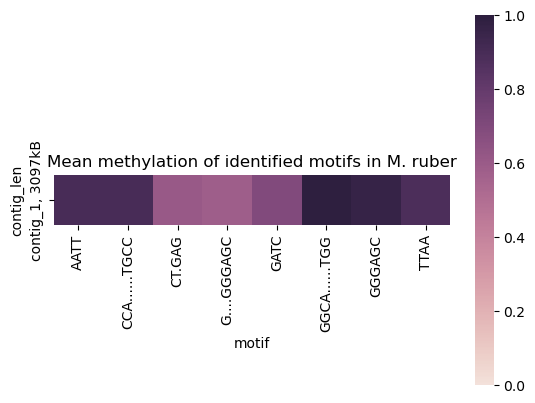

In [18]:
mr_motifs_plot = mr_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(mr_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(mr_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), cmap = cmap, square=True, vmin = 0, vmax = 1);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in M. ruber");

# Geobacillus

In [10]:
gb_assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
gb_pileup = nm.load_pileup("../data/geobacillus/modkit.pileup.bed")

In [11]:
gb_motifs = nm.evaluate.process_sample(gb_assembly, gb_pileup.pileup, min_read_methylation_fraction = 0.8)

DEBUG: ....................G.................... | cdf score: 0.000 | n seqs:       19 | max kl: inf
DEBUG: .........G..........G.................... | cdf score: 0.000 | n seqs:        9 | max kl: 0.795
DEBUG: Too few sequences left
DEBUG: ....................C.................... | cdf score: 0.000 | n seqs:       13 | max kl: inf
DEBUG: ....................CG................... | cdf score: 0.000 | n seqs:        8 | max kl: 0.893
DEBUG: Too few sequences left
DEBUG: ....................C.................... | cdf score: 0.000 | n seqs:      360 | max kl: inf
DEBUG: ....................C...C................ | cdf score: 0.000 | n seqs:      300 | max kl: 0.621
DEBUG: ....................CG..C................ | cdf score: 0.000 | n seqs:      216 | max kl: 1.173
DEBUG: Too few sequences left
DEBUG: ....................A.................... | cdf score: 0.000 | n seqs:      847 | max kl: inf
DEBUG: ....................A.C.................. | cdf score: 0.000 | n seqs:      806 | max k

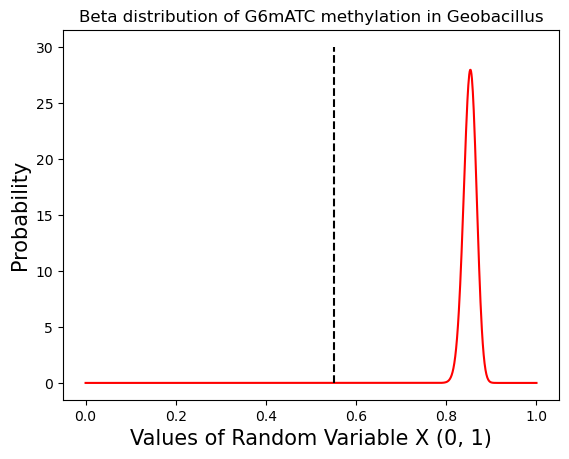

In [14]:
gb_motifs.filter(pl.col("motif") == "GATC").filter(pl.col("contig") == "contig_3")[0, 1].plot();
plt.vlines(0.55, 0, 30, color="black", linestyle="dashed");
plt.title("Beta distribution of G6mATC methylation in Geobacillus");

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f23a62ffb20>


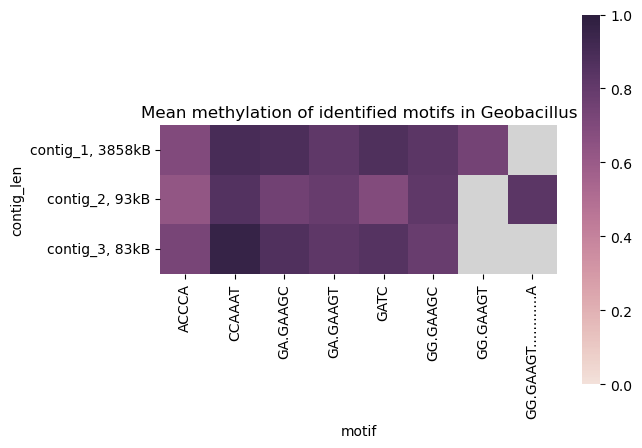

In [15]:
log.basicConfig(level=log.INFO);
gb_motifs_plot = gb_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(gb_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(gb_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), cmap = cmap, square=True, vmin = 0, vmax = 1);
heatmap.set_facecolor('lightgray')
plt.title("Mean methylation of identified motifs in Geobacillus");

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f2239329ac0>


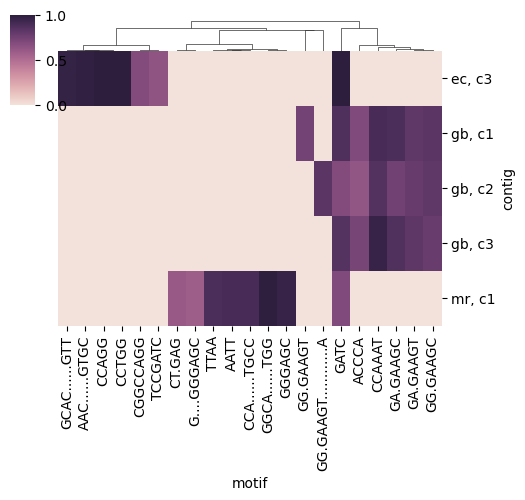

In [71]:
motifs_all_samples = pl.concat(
    [
        gb_motifs_plot.with_columns(pl.lit("gb").alias("species")),
        mr_motifs_plot.with_columns(pl.lit("mr").alias("species")),
        ec_motifs_plot.with_columns(pl.lit("ec").alias("species"))
    ]
).with_columns(
    (pl.col("species").apply(lambda s: f"{s}, ") + pl.col("contig").str.replace("contig_", "c")).alias("contig")
).sort("species", descending = True)

cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.clustermap(
    motifs_all_samples.to_pandas().pivot(values = "mean", index = "contig", columns = "motif").fillna(0), 
    cmap = cmap, vmin = 0, vmax = 1,
    row_cluster=False, col_cluster=True, dendrogram_ratio=0.1, figsize = (5, 5));
heatmap.ax_heatmap.yaxis.set_ticklabels(heatmap.ax_heatmap.yaxis.get_ticklabels(), rotation=0, ha='left');